
Import  package

In [2]:

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from qcat.visualization.readout_fidelity import plot_readout_fidelity
from qcat.analysis.state_discrimination.readout_fidelity import GMMROFidelity
from qcat.analysis.state_discrimination import p01_to_Teff


c:\Users\shiau\.conda\envs\PYQUM-server-offline\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


File formate translate (QM)

In [3]:
dataset = xr.open_dataset(r"c:\Users\shiau\OneDrive\文件\DRKEq1_SingleShot(0)_H19M17S0.nc")
print(dataset)
transposed_data = dataset.transpose("mixer", "state", "index")

format_data = {}
for ro_name, data in transposed_data.data_vars.items(): 
    new_data = data.values*1000
    format_data[ro_name] = new_data
    print(ro_name)


OSError: [Errno 22] Invalid argument: 'c:\\Users\\shiau\\OneDrive\\文件\\DRKEq1_SingleShot(0)_H19M17S0.nc'

File formate translate (Qblox)

In [3]:
dataset = xr.open_dataset(r"d:\DRKEq1_SingleShot(0)_H11M44S1.nc")
# print(dataset)
shot_num = dataset["g"].values.shape[-1]
combined_array = np.array([dataset["g"].values,dataset["e"].values])
format_dataset = xr.Dataset(
    {"q0_ro":(["state", "mixer", "index"], combined_array)},
    coords={ "mixer":np.array(["I","Q"]), "state":np.array([0,1]), "index": np.arange(shot_num) }
)
format_dataset = format_dataset.transpose("mixer", "state", "index")

print(format_dataset)

format_data = {}
format_data["q0_ro"] = format_dataset["q0_ro"].values*1000



<xarray.Dataset> Size: 2MB
Dimensions:  (state: 2, mixer: 2, index: 50000)
Coordinates:
  * mixer    (mixer) <U1 8B 'I' 'Q'
  * state    (state) int32 8B 0 1
  * index    (index) int32 200kB 0 1 2 3 4 5 ... 49995 49996 49997 49998 49999
Data variables:
    q0_ro    (mixer, state, index) float64 2MB -0.001649 -0.00134 ... -0.00116


Create Discriminator object to analyze data

In [4]:


# Prepare data
ro_name = "q0_ro"
training_data = format_data[ro_name] #your (2,2,N) data to train
print(type(training_data), training_data.shape)
dataset = xr.DataArray(training_data, coords= [("mixer",["I","Q"]), ("prepared_state",[0,1]), ("index",np.arange(training_data.shape[2]))] )
# print(dataset)

# Do analysis
gmm2d_fidelity = GMMROFidelity()
gmm2d_fidelity._import_data(dataset)
gmm2d_fidelity._start_analysis()
g1d_fidelity = gmm2d_fidelity.export_G1DROFidelity()
print( gmm2d_fidelity.discriminator.label_map.label_assign.result)

# Get parameters
prepare_state = list(dataset.coords["prepared_state"].values)
print( f"prepare {prepare_state}")

for i in prepare_state:
    print(f"prepare {i} state")
    print(f"GMM threshold")
    gmm2d_prob = gmm2d_fidelity.state_probability[i]
    print(f"p{i}0={gmm2d_prob[0]}")
    print(f"p{i}1={gmm2d_prob[1]}")

    print(f"Gaussian fiting")
    g1d_prob, bin_center, hist, fit_result = g1d_fidelity.g1d_dist[i]
    print(f"p{i}0={g1d_prob[0]}")
    print(f"p{i}1={g1d_prob[1]}")

    print(f"signal:{g1d_fidelity.discriminator.signal}")
    print(f"noise:{g1d_fidelity.discriminator.noise}")
    print(f"snr:{g1d_fidelity.discriminator.snr}")

effective_T = p01_to_Teff(g1d_fidelity.g1d_dist[0][0][1], 4e9)
print(effective_T)
# For loop end here


<class 'numpy.ndarray'> (2, 2, 50000)
{'state': array([0, 1]), 'label': array([0, 1], dtype=int64)}
prepare [0, 1]
prepare 0 state
GMM threshold
p00=0.98384
p01=0.01616
Gaussian fiting
p00=0.9872152373217322
p01=0.012784762678267843
signal:4.339434455574647
noise:[0.81798439 0.83165139]
snr:5.261081874597607
prepare 1 state
GMM threshold
p10=0.13772
p11=0.86228
Gaussian fiting
p10=0.11673730152807046
p11=0.8832626984719295
signal:4.339434455574647
noise:[0.81798439 0.83165139]
snr:5.261081874597607
0.04416789286060804


Plot fidelity

(2, 2, 50000)
<xarray.DataArray (mixer: 2, prepared_state: 2, index: 50000)> Size: 2MB
array([[[-1.64891711, -1.33952125, -0.85067579, ..., -2.40807686,
         -2.05699397,  1.2304185 ],
        [ 1.51343429,  2.35596808,  0.94186615, ...,  1.20110731,
          0.28887803,  1.17081908]],

       [[-3.58410682, -4.79400749, -5.01351571, ..., -5.19557075,
         -4.57971014, -0.87184498],
        [-0.65233675,  0.24947077, -1.20924931, ..., -0.44715844,
         -0.34815177, -1.16007165]]])
Coordinates:
  * mixer           (mixer) <U1 8B 'I' 'Q'
  * prepared_state  (prepared_state) int32 8B 0 1
  * index           (index) int32 200kB 0 1 2 3 4 ... 49996 49997 49998 49999


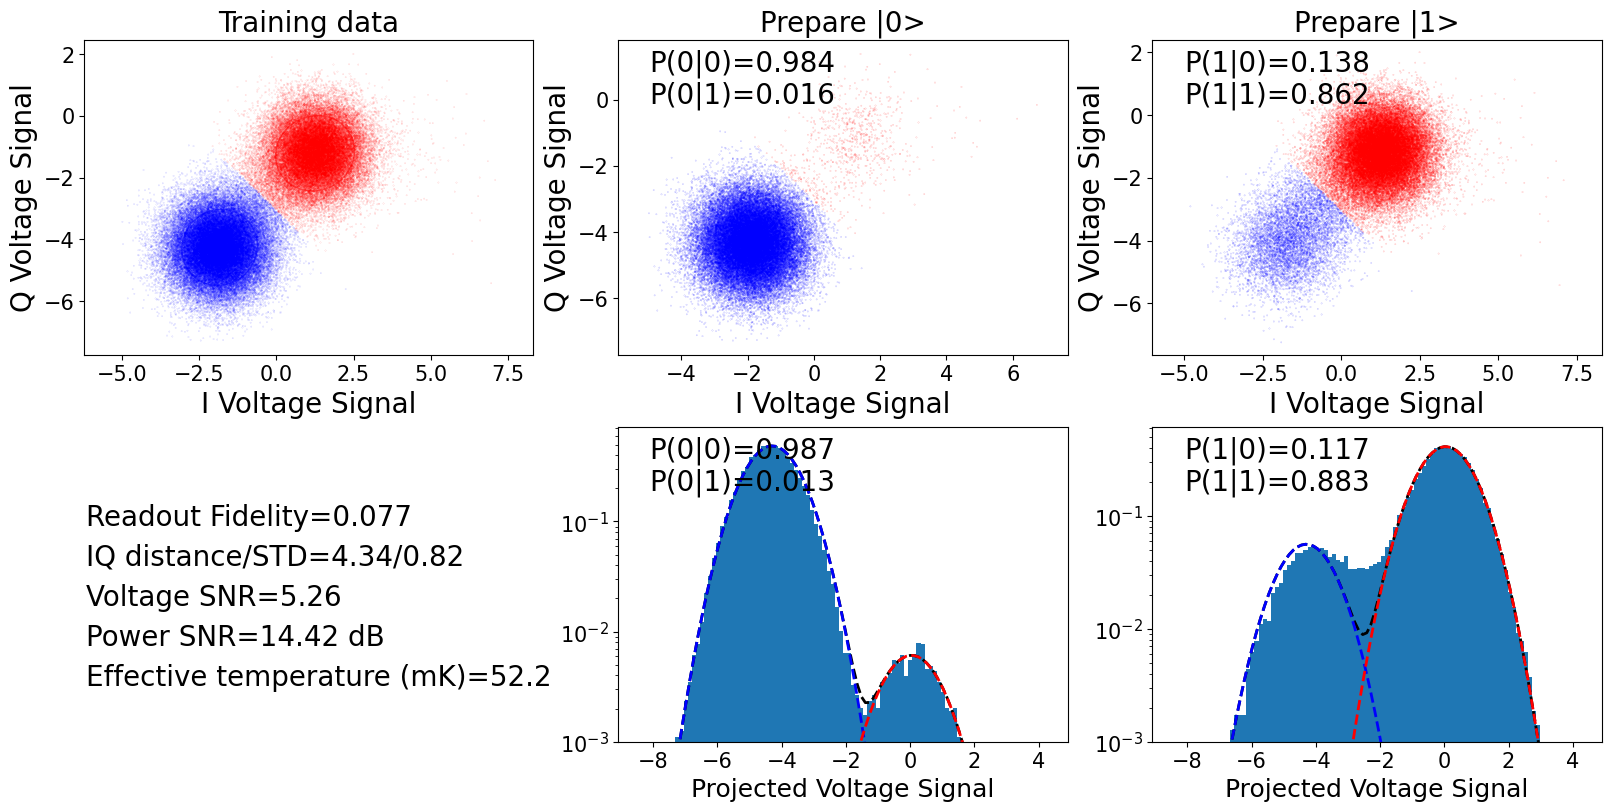

In [4]:

single_name = ro_name
# for ro_name, data in format_data.items(): 
for ro_name, data in [(single_name, format_data[single_name])]:
    print(data.shape)
    dataset = xr.DataArray(training_data, coords= [("mixer",["I","Q"]), ("prepared_state",[0,1]), ("index",np.arange(data.shape[2]))] )
    print(dataset)

    # Do analysis
    gmm2d_fidelity = GMMROFidelity()
    gmm2d_fidelity._import_data(dataset)
    gmm2d_fidelity._start_analysis()
    g1d_fidelity = gmm2d_fidelity.export_G1DROFidelity()
    
    plot_readout_fidelity( dataset, gmm2d_fidelity, g1d_fidelity, 4.73e9 )

plt.show()
